<a href="https://colab.research.google.com/github/RayAKaan/Machine-Learning/blob/main/FDTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, roc_curve, auc

df = pd.read_csv("Food_Delivery_Time_Prediction.csv")

df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [160]:
df.fillna(df.select_dtypes(include=['number']).mean(), inplace=True)

df.dropna(inplace=True)
# Make a copy of the dataframe to avoid modifying the original
df_encoded = df.copy()

# Identify categorical columns (object type)
categorical_columns = df_encoded.select_dtypes(include=['object']).columns

# Encode categorical features using Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # Store encoders in case you need them later

In [161]:
categorical_cols = ["Weather_Conditions", "Traffic_Conditions", "Vehicle_Type", "Order_Priority"]
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

df.dtypes

df["Order_Time"] = df["Order_Time"].map({"Morning": 0, "Afternoon": 1, "Evening": 2, "Night": 3})


In [162]:
df["Experience_Level"] = df["Delivery_Person_Experience"].apply(lambda x: "High" if x > 5 else "Low")

df["Experience_Level"] = LabelEncoder().fit_transform(df["Experience_Level"])

df.head()


,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount,Experience_Level
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,1,2,4,2,1,2,4.1,3.0,26.22,1321.10,81.54,1
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,0,2,8,1,3,2,4.5,4.2,62.61,152.21,29.02,0
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,2,2,9,0,3,1,3.3,3.4,48.43,1644.38,64.17,0
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,0,1,2,2,2,1,3.2,3.7,111.63,541.25,79.23,1
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,1,0,6,1,3,1,3.5,2.8,32.38,619.81,2.34,0


In [163]:
def extract_coordinates(coord_str):
    try:
        lat, lon = map(float, coord_str.strip("()").split(","))
        return lat, lon
    except:
        return None, None  # If format is wrong or missing

# Handle Restaurant_Location
if "Restaurant_Location" in df.columns:
    df["Restaurant_Lat"], df["Restaurant_Lon"] = zip(*df["Restaurant_Location"].apply(extract_coordinates))
    df.drop(columns=["Restaurant_Location"], inplace=True)

# Handle Customer_Location
if "Customer_Location" in df.columns:
    df["Customer_Lat"], df["Customer_Lon"] = zip(*df["Customer_Location"].apply(extract_coordinates))
    df.drop(columns=["Customer_Location"], inplace=True)

In [164]:
X = df.drop(columns=["Order_ID",])  # Keep all columns
y = df["Delivery_Time"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [165]:
# Convert Order_Time to categorical time periods
df["Order_Hour"] = df["Order_Time"] % 24  #
df["Time_Period"] = pd.cut(df["Order_Hour"], bins=[0, 6, 12, 18, 24], labels=[0, 1, 2, 3])  # Morning, Afternoon, Evening, Night

df.drop(columns=["Order_Time"], inplace=True)
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col], errors='ignore')
        except:
            pass  # If conversion fails, skip it

# Step 4: Handle remaining categorical/string columns
categorical_cols = df.select_dtypes(include='object').columns
label_encoders = {}

for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip()  # Remove spaces
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save for inverse transform if needed


<ipython-input-165-b79bc94d2c25>:9: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [166]:
# Fill missing values in "Time_Period" with mode if available
if df is not None and "Time_Period" in df.columns:
    mode_value = df["Time_Period"].mode()
    if not mode_value.empty:
        df["Time_Period"] = df["Time_Period"].fillna(mode_value.iloc[0])  # Use iloc for clarity

# Fill all remaining missing values in the dataset with mode values
if df is not None and not df.mode().empty:
    df.fillna(df.mode().iloc[0], inplace=True)  # Use inplace=True for efficiency

# Ensure X_train and X_test are updated after modifying df
if 'X_train' in globals() and 'X_test' in globals():
    mode_values = df.mode().iloc[0]
    X_train.fillna(mode_values, inplace=True)
    X_test.fillna(mode_values, inplace=True)


# Function to extract latitude and longitude from a coordinate string
def extract_coordinates(coord_str):
    try:
        lat, lon = map(float, coord_str.strip("()").split(", "))  # Convert string to float
        return lat, lon
    except ValueError:
        return None, None  # Handle errors gracefully

# Convert coordinate columns to numerical format
for col in ["Order_Location", "Customer_Location"]:
    if col in df.columns:
        df[f"{col}_Lat"], df[f"{col}_Lon"] = zip(*df[col].apply(extract_coordinates))
        df.drop(columns=[col], inplace=True)  # Drop original string column


In [167]:
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)


In [168]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Absolute Error: 0.00
R² Score: 1.00


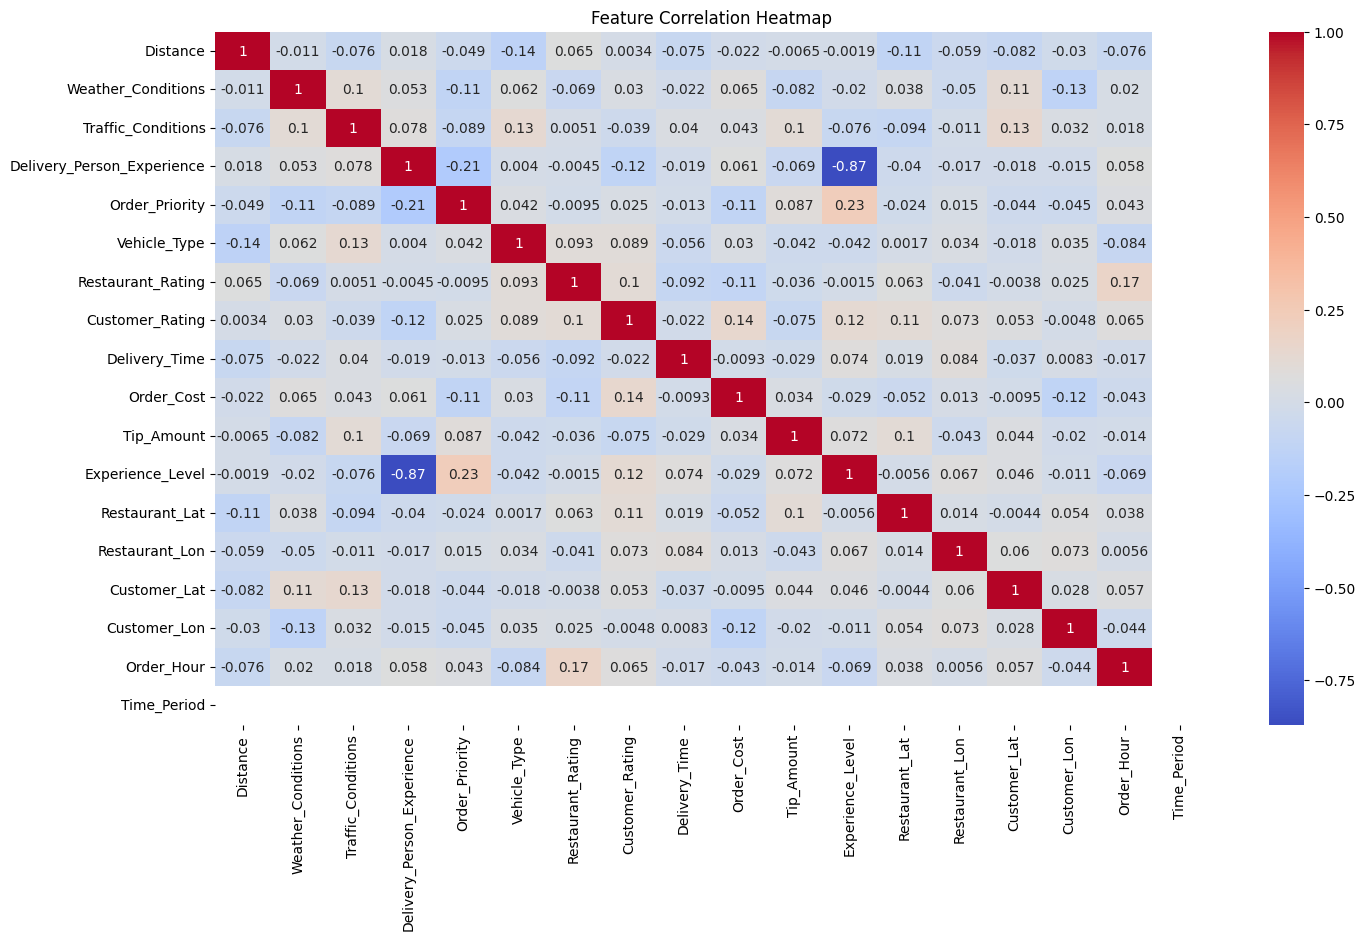

In [169]:
# Remove non-numeric columns before correlation
df_numeric = df.drop(columns=["Order_ID"])

# Generate the heatmap only for numeric data
plt.figure(figsize=(16, 9))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


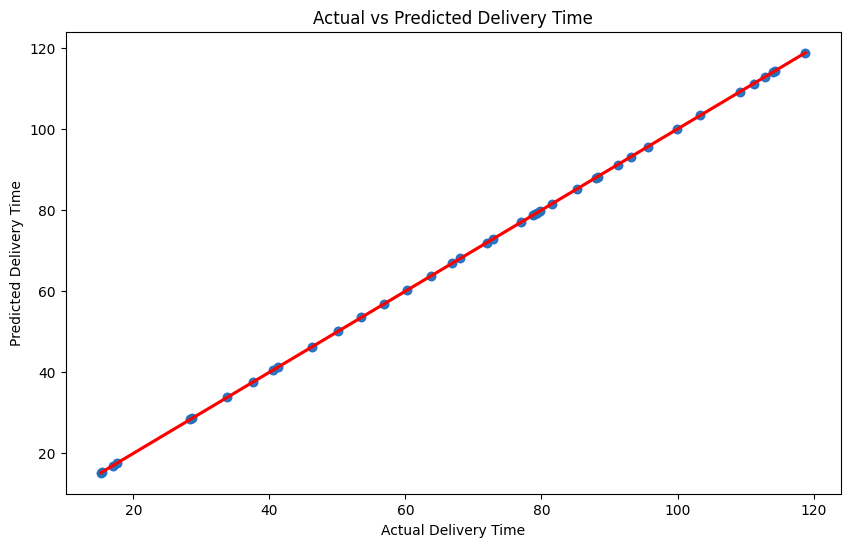

In [170]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red"})
plt.xlabel("Actual Delivery Time")
plt.ylabel("Predicted Delivery Time")
plt.title("Actual vs Predicted Delivery Time")
plt.show()


In [171]:
# Create a new categorical column for classification
def classify_delivery_time(time):
    if time <= 20:
        return "Fast"
    elif time <= 40:
        return "Medium"
    else:
        return "Slow"

df['Delivery_Speed'] = df['Delivery_Time'].apply(categorize_speed)
X = df.drop(['Delivery_Time', 'Delivery_Speed'], axis=1)
y = df['Delivery_Speed']


df["Delivery_Speed"] = df["Delivery_Time"].apply(classify_delivery_time)

speed_encoder = LabelEncoder()
df["Delivery_Speed_Label"] = speed_encoder.fit_transform(df["Delivery_Speed"])

# Check label mapping (optional)
print(dict(zip(speed_encoder.classes_, speed_encoder.transform(speed_encoder.classes_))))


{'Fast': np.int64(0), 'Medium': np.int64(1), 'Slow': np.int64(2)}


In [172]:
X_cls = df.drop(columns=["Delivery_Time", "Delivery_Speed", "Delivery_Speed_Label", "Order_ID"])
y_cls = df["Delivery_Speed_Label"]

# Split the data
from sklearn.model_selection import train_test_split
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)


In [173]:
scaler = StandardScaler()
X_cls_train_scaled = scaler.fit_transform(X_cls_train)
X_cls_test_scaled = scaler.transform(X_cls_test)


In [174]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_cls_train_scaled, y_cls_train)

# Predict on test data
y_cls_pred = log_model.predict(X_cls_test_scaled)


In [175]:
ros = RandomOverSampler(random_state=42)
X_cls_resampled, y_cls_resampled = ros.fit_resample(X_cls, y_cls)

# Split into train and test
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls_resampled, y_cls_resampled, test_size=0.2, random_state=42)

# Train Logistic Regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_cls_train, y_cls_train)

# Predictions
y_cls_pred = clf.predict(X_cls_test)

# Evaluation
print("Classification Report:")
print(classification_report(y_cls_test, y_cls_pred))
print("Accuracy Score:", accuracy_score(y_cls_test, y_cls_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.87      0.70        30
           1       0.55      0.60      0.57        30
           2       0.53      0.28      0.36        36

    accuracy                           0.56        96
   macro avg       0.55      0.58      0.55        96
weighted avg       0.55      0.56      0.53        96

Accuracy Score: 0.5625


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

        Fast       0.59      0.87      0.70        30
      Medium       0.55      0.60      0.57        30
        Slow       0.53      0.28      0.36        36

    accuracy                           0.56        96
   macro avg       0.55      0.58      0.55        96
weighted avg       0.55      0.56      0.53        96

Accuracy Score: 0.5625


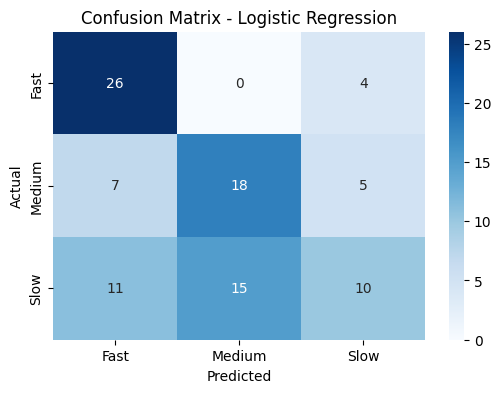

In [176]:
# Evaluation metrics
print("Classification Report:\n", classification_report(y_cls_test, y_cls_pred, target_names=speed_encoder.classes_))
print("Accuracy Score:", accuracy_score(y_cls_test, y_cls_pred))

# Confusion Matrix
cm = confusion_matrix(y_cls_test, y_cls_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=speed_encoder.classes_, yticklabels=speed_encoder.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [177]:
X = df.drop(['Delivery_Time', 'Delivery_Speed'], axis=1)
y = df['Delivery_Speed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



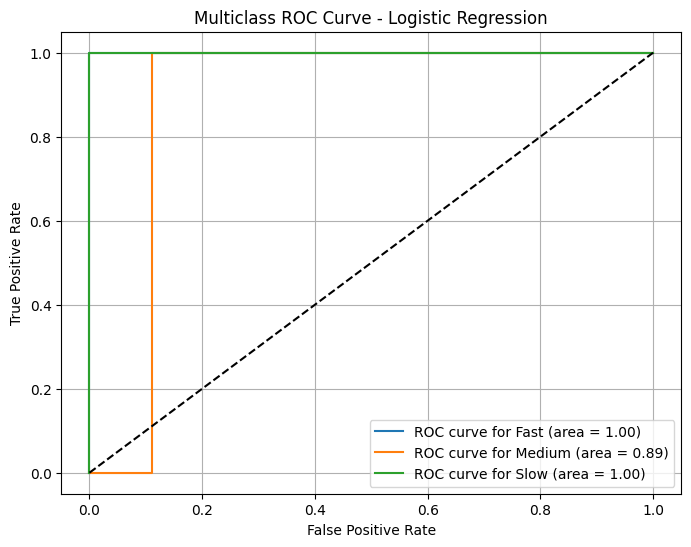

In [178]:
y_bin = label_binarize(y, classes=['Fast', 'Medium', 'Slow'])
n_classes = y_bin.shape[1]

# Fit One-vs-Rest Logistic Regression
classifier = OneVsRestClassifier(LogisticRegression(max_iter=1000))
classifier.fit(X_train_scaled, label_binarize(y_train, classes=['Fast', 'Medium', 'Slow']))

# Predict probabilities
y_score = classifier.predict_proba(X_test_scaled)

# Plot ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=['Fast', 'Medium', 'Slow'])[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(['Fast', 'Medium', 'Slow']):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_label} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [180]:
classes = ['Fast', 'Medium', 'Slow']

for i in range(len(classes)):
    print(f"AUC for class {classes[i]}: {roc_auc[i]:.2f}")


AUC for class Fast: 1.00
AUC for class Medium: 0.89
AUC for class Slow: 1.00
